<a href="https://colab.research.google.com/github/xavierpuigf/watch_and_help/blob/main/demo/watch_and_help_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VirtualHome Collab Demo

This demo shows how to use VirtualHome to build synthetic scenes and run activites by one or multiple agents. 

**Remember to activate a GPU environment in order to run this demo.**

## Install Packages

In [28]:
import matplotlib.pyplot as plt
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !pip install git+https://github.com/xavierpuigf/colabstreamer
    !git clone https://github.com/xavierpuigf/virtualhome.git
    import colabstreamer
    colabstreamer.config_all()
    _xorg = colabstreamer.open_xorg()
else:  
    import getpass
    import os
    password = getpass.getpass()
    %cd ../..
    !git clone https://github.com/xavierpuigf/virtualhome.git
    %cd virtualhome/helper_scripts
    command = 'sudo -S python startx.py 1'
    os.popen(command, 'w').write(password+'\n')
    %cd ../../watch_and_help
    

KeyboardInterrupt: 

## Download simulator

In [2]:
# Download the simulator
%cd ../
! wget http://virtual-home.org/linux_exec.zip
! unzip -q linux_exec.zip
fpath = os.getcwd()

/data/vision/torralba/frames/data_acquisition/SyntheticStories/MultiAgent/challenge/release_final/release_github


# Start simulation

In [3]:
import sys
sys.path.append('./virtualhome')
from simulation.unity_simulator import comm_unity
import demo.utils_demo as utils_demo
%matplotlib notebook
import IPython.display
comm = comm_unity.UnityCommunication(file_name=f"{fpath}/linux_exec.x86_64", port='8082', x_display="1")

/data/vision/torralba/frames/tools/anaconda3/envs/vh_challenge/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


['/data/vision/torralba/frames/data_acquisition/SyntheticStories/MultiAgent/challenge/release_final/release_github/linux_exec.x86_64', '-batchmode', '-http-port=8082', '-logFile /data/vision/torralba/frames/data_acquisition/SyntheticStories/MultiAgent/challenge/release_final/release_github/Player_8082.log']
Getting connection...


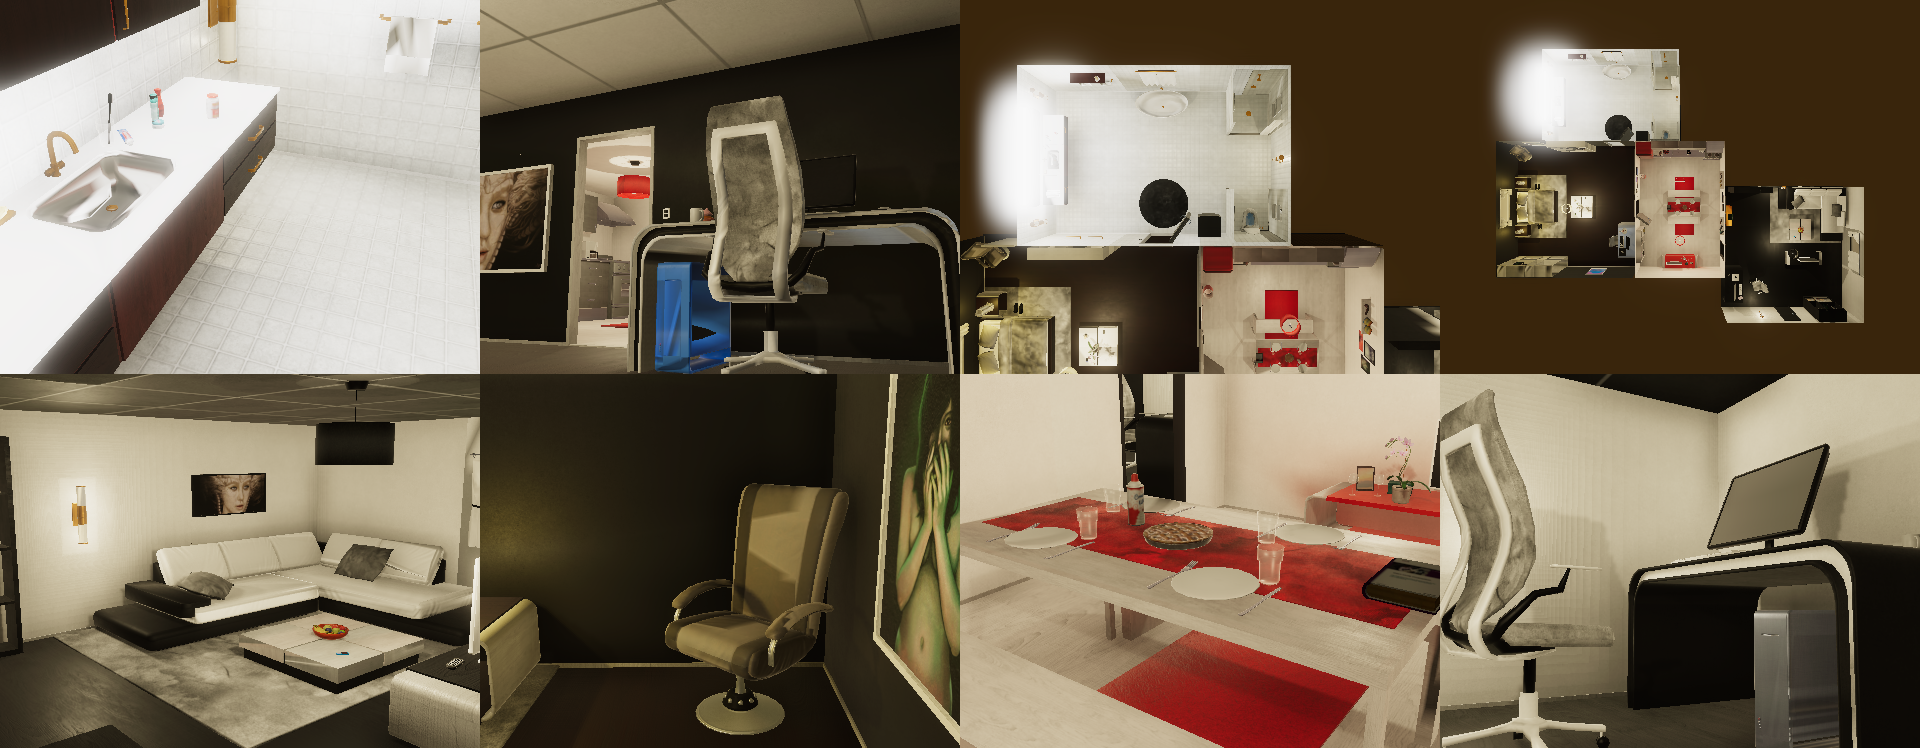

In [4]:
comm.reset(0)
indices = [3, 32, -5, -1, -20, 15, 48, -8]
img_final = utils_demo.display_scene_cameras(comm, indices, nrows=2)
IPython.display.display(img_final)


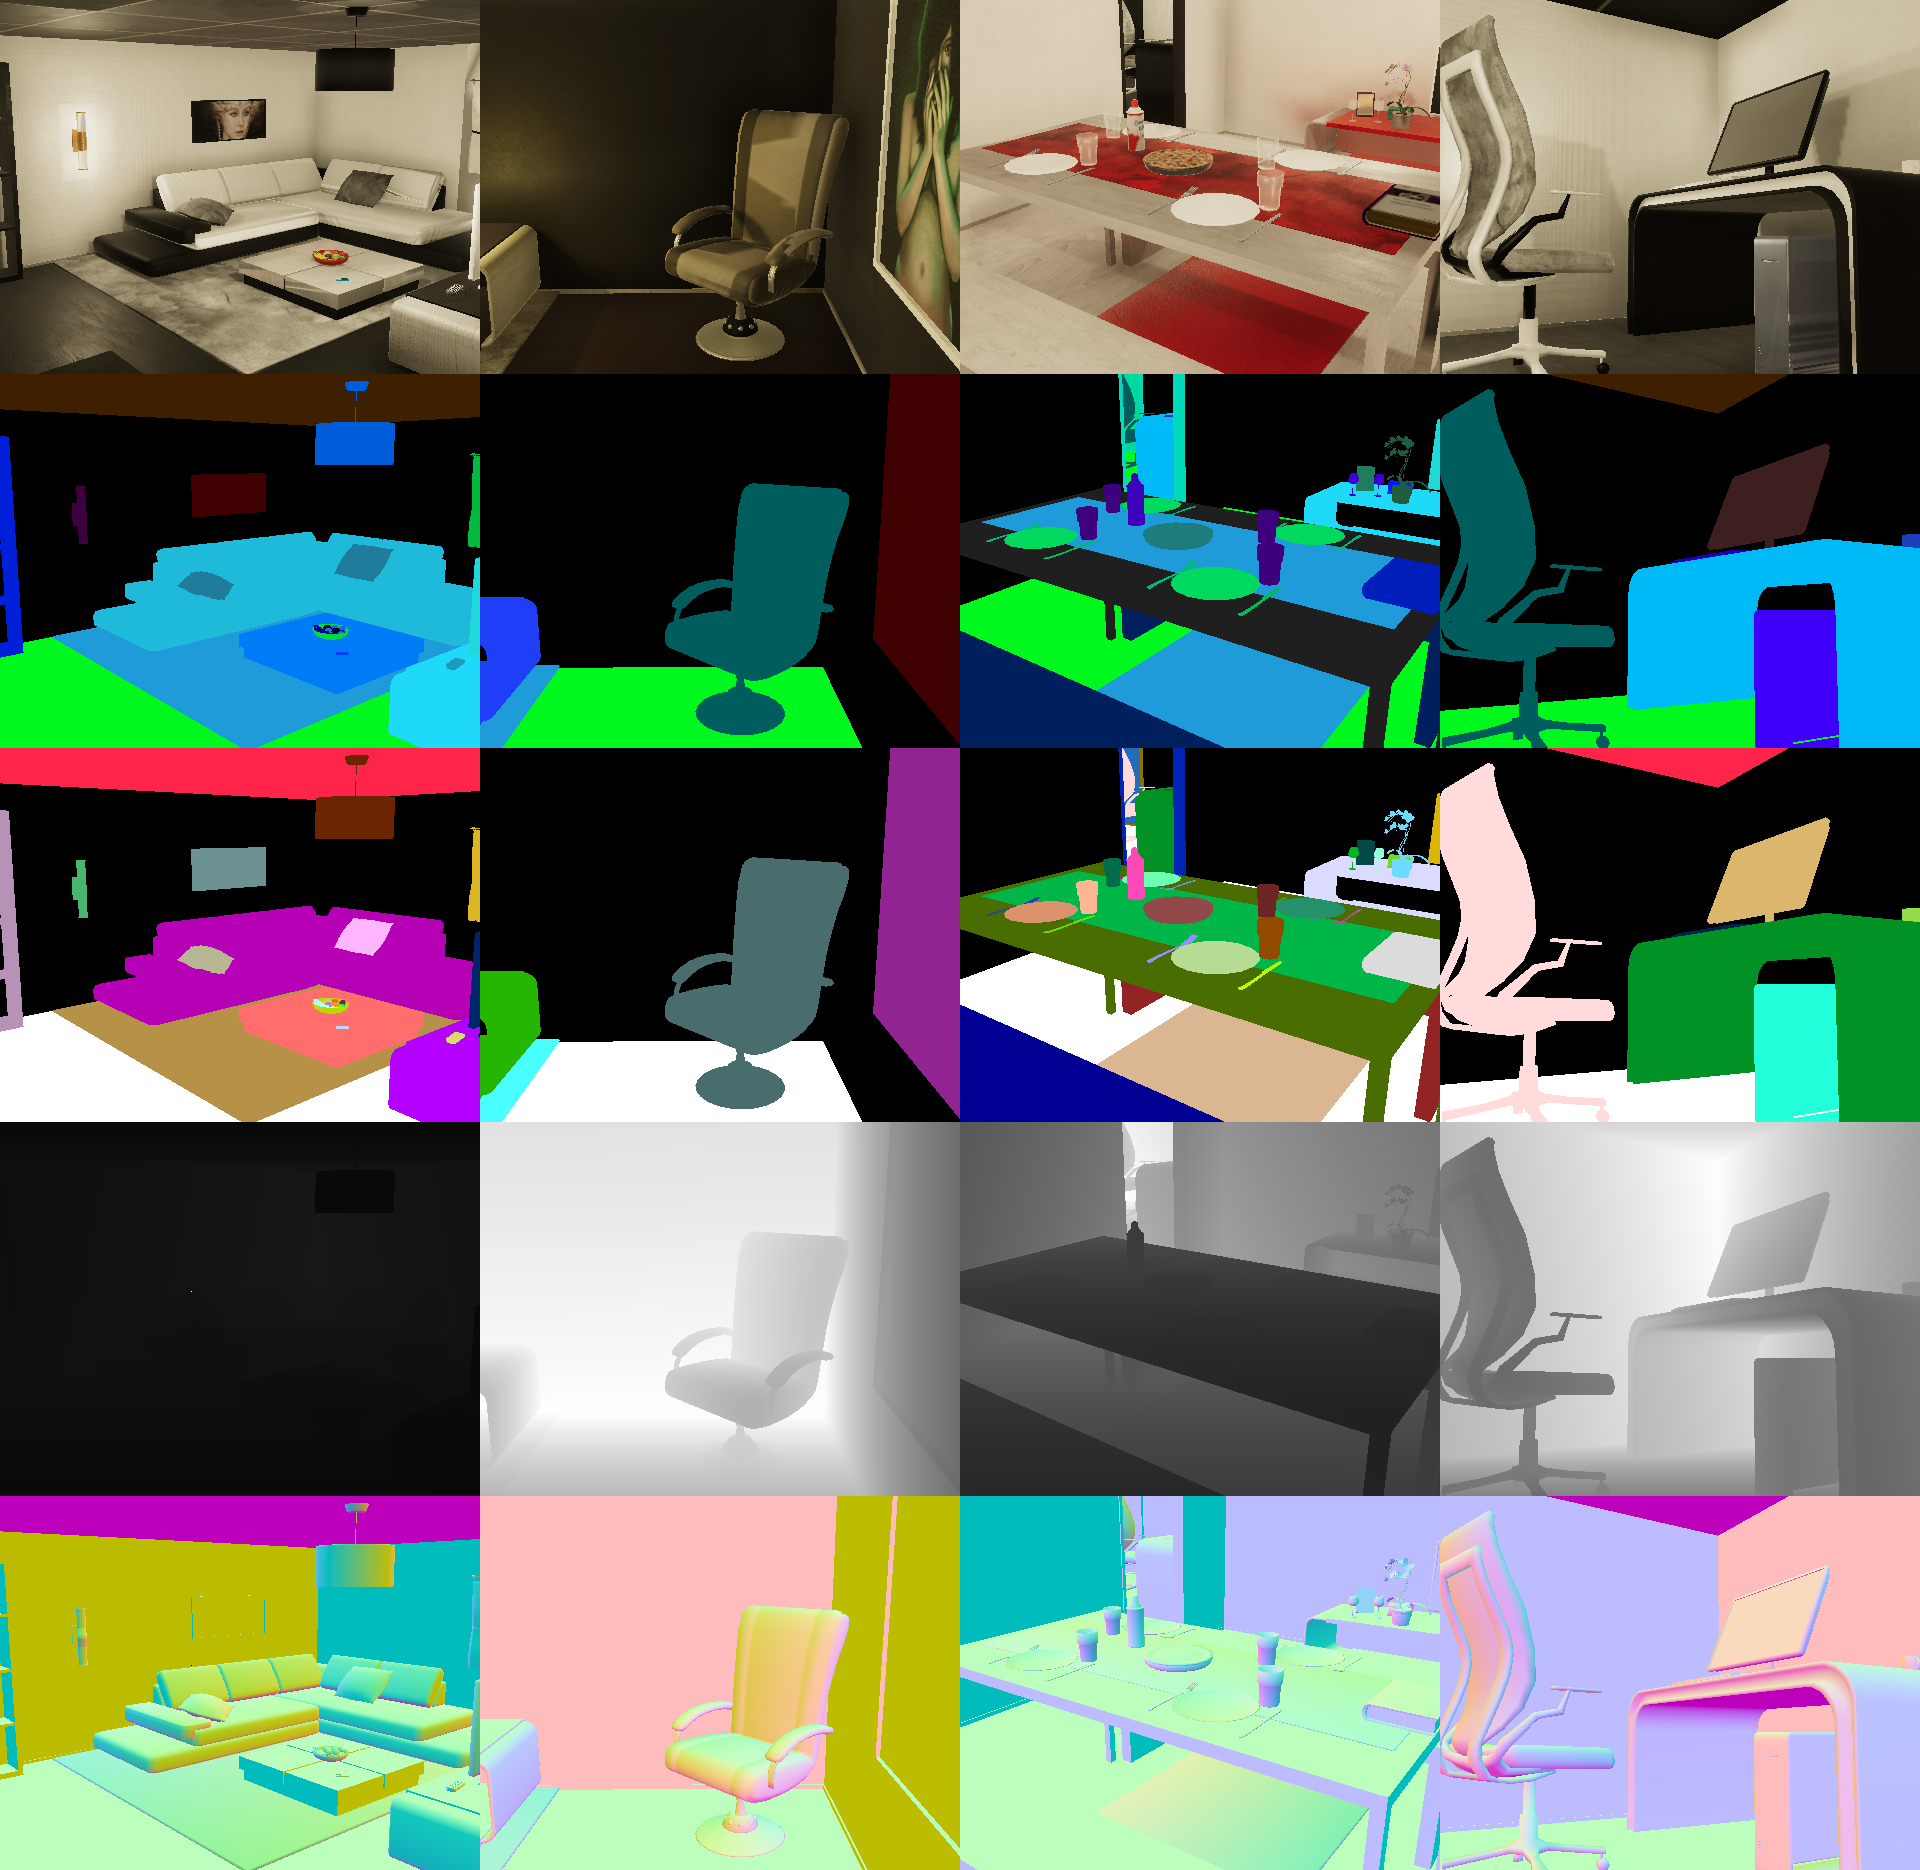

In [5]:
indices = [-20, 15, 48, -8]
img_final = utils_demo.display_scene_modalities(
    comm, 
    indices, 
    modalities=['normal', 'seg_class', 'seg_inst', 'depth', 'surf_normals'], nrows=5)
IPython.display.display(img_final)

## Modify the scene

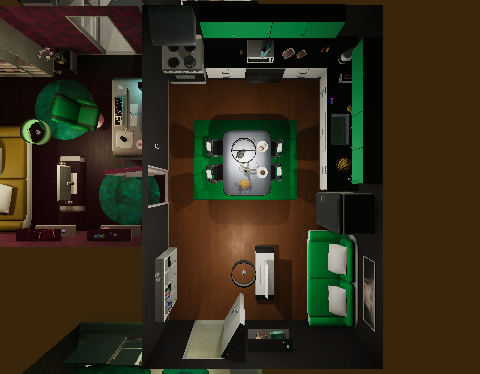

In [6]:
comm.reset(4)
imgs_prev = utils_demo.get_scene_cameras(comm, [-4])
utils_demo.display_grid_img(imgs_prev, nrows=1)

In [7]:
success, graph = comm.environment_graph();
sofa = utils_demo.find_nodes(graph, class_name='sofa')[-2]
print(sofa)

{'id': 139, 'category': 'Furniture', 'class_name': 'sofa', 'prefab_name': 'PRE_FUR_Sofa_02_03_02_01', 'obj_transform': {'position': [6.888, 0.051, -4.879], 'rotation': [0.0, 1.0, 0.0, 3.57627869e-07]}, 'bounding_box': {'center': [6.89529371, 0.5715897, -4.879], 'size': [0.9469976, 0.885002553, 2.155935]}, 'properties': ['SURFACES', 'SITTABLE', 'LIEABLE', 'MOVABLE'], 'states': []}


In [8]:
utils_demo.add_node(graph, {'class_name': 'cat', 
                   'category': 'Animals', 
                   'id': 1000, 
                   'properties': [], 
                   'states': []})
utils_demo.add_edge(graph, 1000, 'ON', sofa['id'])

In [9]:
success, message = comm.expand_scene(graph)


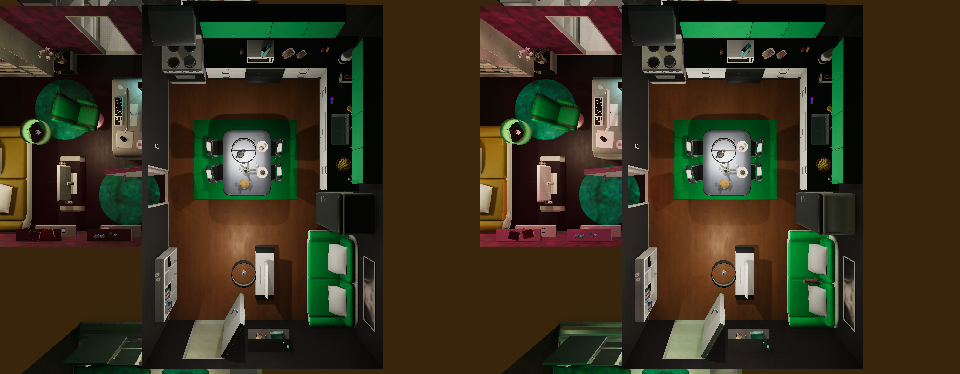

In [10]:
imgs_final = utils_demo.get_scene_cameras(comm, [-4])
utils_demo.display_grid_img(imgs_prev+imgs_final, nrows=1)


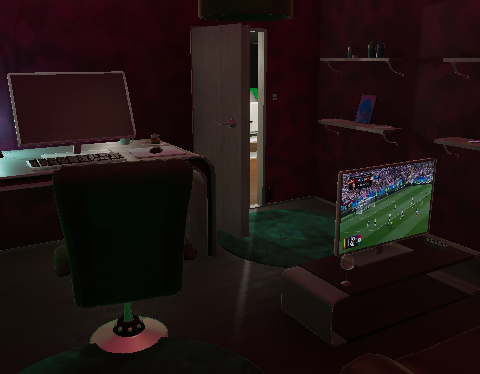

In [15]:

indices = [0]
imgs_prev = utils_demo.get_scene_cameras(comm, indices)
utils_demo.display_grid_img(imgs_prev, nrows=1)

In [16]:
success, graph = comm.environment_graph()
prev_graph = graph
tv_node = [x for x in graph['nodes'] if x['class_name'] == 'tv'][0]
light_node = [x for x in graph['nodes'] if x['class_name'] == 'lightswitch'][0]

In [17]:
tv_node['states'] = ['ON']
light_node['states'] = ['OFF']
_ = comm.expand_scene(graph)
last_graph = graph

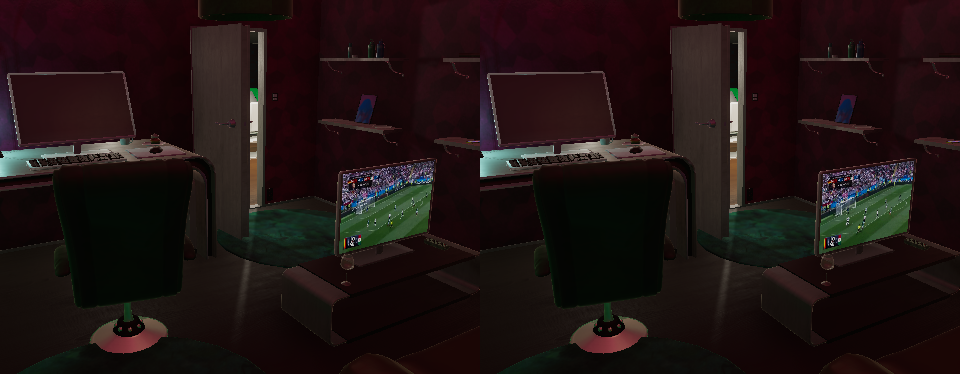

In [18]:

imgs_final = utils_demo.get_scene_cameras(comm, indices)
utils_demo.display_grid_img(imgs_prev+imgs_final, nrows=1)

## Generating Scripts

We now can start scenes, visualize them and modify them. The last step is to perform activities in them. We do this by defining scripts: Lists of instructions that will be executed in sequence. Each instruction contains an action, an object, and an id. The id should match with the id of each of the nodes in the environment graph.



### Adding a character
The first step is to add agents in the environment, that will be performing the activity. You can specify which agent you want to add and the room where you want to add it


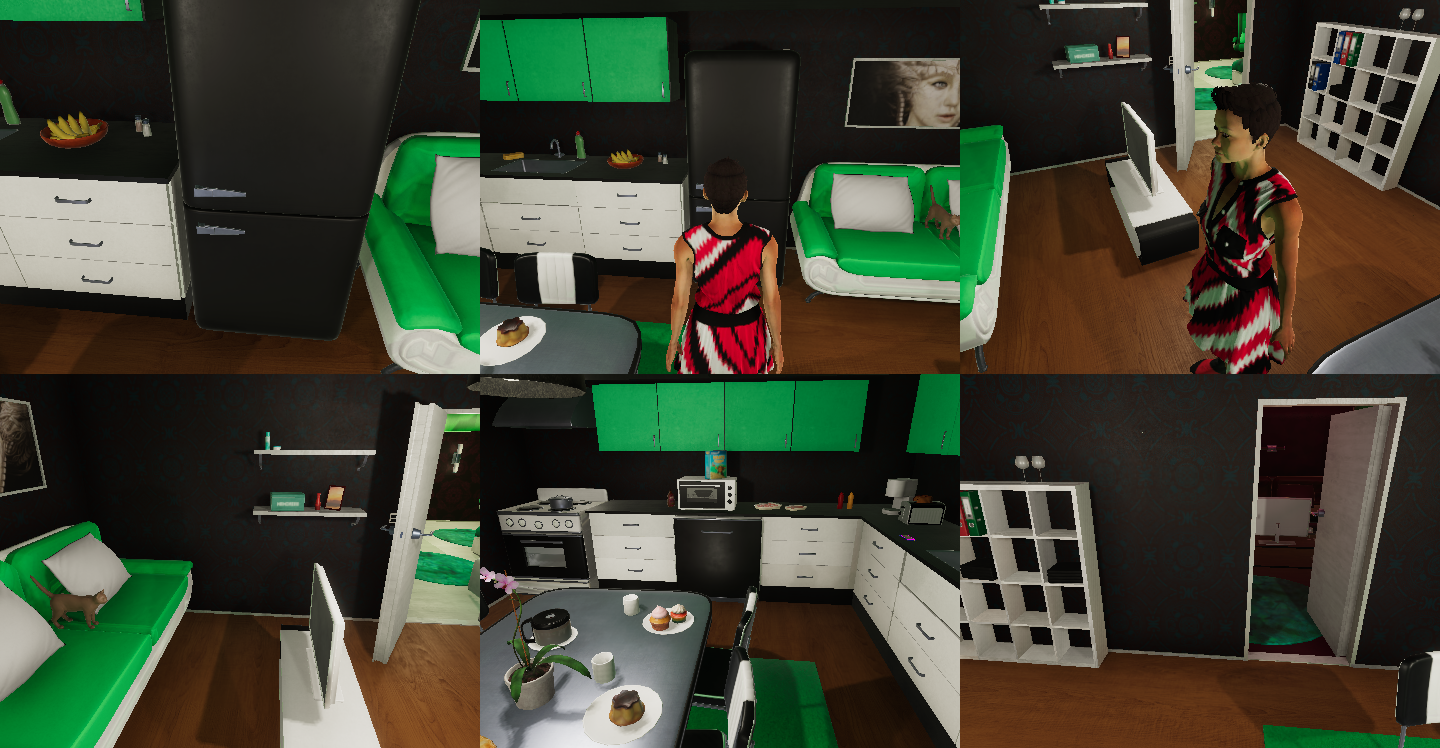

In [19]:
comm.reset(4)
tv_node['states'] = ['OFF']
comm.expand_scene(prev_graph)
comm.add_character('chars/Female2', initial_room='kitchen')
s, g = comm.environment_graph()
cat_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'cat'][0]

s, nc = comm.camera_count()
indices = range(nc - 6, nc)
imgs_prev = utils_demo.get_scene_cameras(comm, indices)
utils_demo.display_grid_img(imgs_prev, nrows=2)

## Generating the first script
Let's start by interacting witht the cat and the sofa that we set up before. The cat had id 1000. The sofa was stored in a variable sofa containing that node. We can query its id directly. This sequence will make the agent walk to the sofa, grab the cat and sit in the sofa.

In [20]:
script = ['<char0> [Walk] <sofa> ({})'.format(sofa['id']),
          '<char0> [Find] <cat> ({})'.format(cat_id),
          '<char0> [Grab] <cat> ({})'.format(cat_id),
          '<char0> [Sit] <sofa> ({})'.format(sofa['id'])]

In [21]:
success, message = comm.render_script(script=script,
                                      processing_time_limit=60,
                                      find_solution=False,
                                      image_width=320,
                                      image_height=240,  
                                      skip_animation=False,
                                      recording=True,
                                      save_pose_data=True,
                                      file_name_prefix='relax')

In [22]:
path_video = "./Output/"
from simulation.unity_simulator import utils_viz
utils_viz.generate_video(input_path=path_video, prefix='relax', output_path='.')

Video generated at  ./video_normal.mp4


In [23]:
utils_demo.display_vid('./video_normal.mp4')


<char0> [walk] <salmon> (328) | <char1> [walk] <glass> (283)
<char0> [grab] <salmon> (328) | <char1> [grab] <glass> (283)
<char0> [open] <microwave> (314) | <char1> [walk] <sink> (247)
<char0> [putin] <salmon> (328) <microwave> (314) | <char1> [putback] <glass> (283) <sink> (247)
<char0> [close] <microwave> (314) | <char1> [switchon] <faucet> (249)


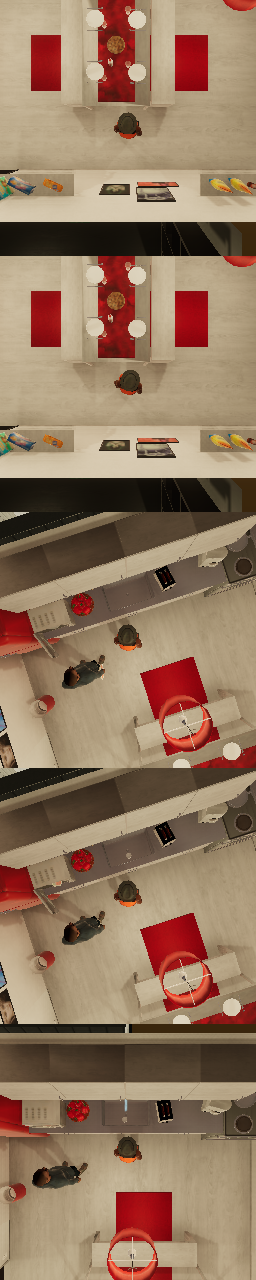

In [40]:
# Reset the scene
comm.reset(0)
s, g = comm.environment_graph()
# Add two agents this time
comm.add_character('Chars/Male2', initial_room='kitchen')
comm.add_character('Chars/Female4', initial_room='bedroom')

# Get nodes for salmon and microwave, glass, faucet and sink
salmon_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'salmon'][0]
microwave_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'microwave'][0]
glass_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'waterglass'][-1]
sink_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'sink'][0]
faucet_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'faucet'][-1]


# Put salmon in microwave
script = [
   '<char0> [walk] <salmon> ({}) | <char1> [walk] <glass> ({})'.format(salmon_id, glass_id),
   '<char0> [grab] <salmon> ({}) | <char1> [grab] <glass> ({})'.format(salmon_id, glass_id),
   '<char0> [open] <microwave> ({}) | <char1> [walk] <sink> ({})'.format(microwave_id, sink_id),
   '<char0> [putin] <salmon> ({}) <microwave> ({}) | <char1> [putback] <glass> ({}) <sink> ({})'.format(salmon_id, microwave_id, glass_id, sink_id),
   '<char0> [close] <microwave> ({}) | <char1> [switchon] <faucet> ({})'.format(microwave_id, faucet_id)
]

s, cc = comm.camera_count()
ims = []
for script_instruction in script:
    s, m = comm.render_script([script_instruction], recording=False, skip_animation=True)
    print(script_instruction)
    # Here you can get an observation, for instance
    s, im = comm.camera_image([cc-7], image_width=256, image_height=256)
    ims.append(im[0])
utils_demo.display_grid_img(ims, nrows=len(ims))
    

## Planner Agent